# Load module


In [ ]:
import sys,os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import scipy
import re

from datasets import load_dataset
from datasets import load_from_disk

from rouge_score import rouge_scorer

from transformers import AutoTokenizer

In [2]:

NUM_PROCS = os.cpu_count() 

print("NUM_PROCS = " ,NUM_PROCS)

device = 'cuda' if torch.cuda.is_available() else 'cpu'


NUM_PROCS =  12


# Load the dataset and analyse some sample 

In [77]:
path_data_result = os.path.join(os.getcwd(),"evaluations/results_evaluation_6497751_43_11/len_and_txt.csv")

data_len = pd.read_csv(path_data_result)

data_len.target_len = data_len.target_len.apply(lambda txt : re.findall(r'\d+', txt)[0]).astype(int)
data_len.input_len = data_len.input_len.apply(lambda txt : re.findall(r'\d+', txt)[0]).astype(int)

data_len

,id,input_len,target_len,generate_len,references_txt,generated_txt
0,f001ec5c4704938247d27a44948eebb37ae98d01,694,41,55,Membership gives the ICC jurisdiction over all...,The Palestinian Authority becomes the 123rd me...
1,230c522854991d053fe98a718b1defa077a8efef,508,58,78,"Theia, a bully breed mix, was apparently hit b...","The dog was hit by a car, apparently whacked o..."
2,4495ba8f3a340d97a9df1476f8a35502bcce1f69,882,46,49,Mohammad Javad Zarif has spent more time with ...,Mohammad Javad Zarif is the Iranian foreign mi...
3,a38e72fed88684ec8d60dd5856282e999dc8c0ca,235,49,59,17 Americans were exposed to the Ebola virus w...,One of the five had a heart-related issue on S...
4,c27cf1b136cc270023de959e7ab24638021bc43f,436,55,59,Student is no longer on Duke University campus...,A Duke student has admitted to hanging a noose...
...,...,...,...,...,...,...
11485,0ac776a4dc09ca97c136f4314fed4defb48a361a,808,52,78,Operators are charging up to 20p a minute - ev...,Mobile phone companies charge customers up to ...
11486,fe89a6a2e28d173e5ad4c6d814c15b95aa969e3f,1857,148,167,Bali Nine ringleaders will face the firing squ...,Bali Nine ringleaders Andrew Chan and Myruan S...
11487,ded2f535cd6ab95d11b5f4ea29bbf2b2d3c55c50,849,89,152,Hardy was convicted of domestic abuse against ...,Greg Hardy was seen trying to drive his Bentle...
11488,30ec5f280eee772a73d181bfc8514defd8026434,1122,41,97,Apple sold more than 61 million iPhones in the...,Apple sold more than 61 million iPhones in the...


In [84]:
data_len["compression_ratio"] = (1-data_len.target_len / data_len.input_len)*100
data_len["compression_ratio_generate"] = (1-data_len.generate_len / data_len.input_len)*100
data_len["ratio_resume_article"] = (data_len.target_len / data_len.input_len)*100
data_len["ratio_generate_resume_article"] = (data_len.generate_len / data_len.input_len)*100
data_len.describe()

,input_len,target_len,generate_len,compression_ratio,compression_ratio_generate,ratio_resume_article,ratio_generate_resume_article
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000
mean,858.563969,72.049869,108.956571,89.523156,84.448671,10.476844,15.551329
std,440.230117,28.992050,29.390737,9.544727,7.434774,9.544727,7.434774
min,66.000000,12.000000,31.000000,-647.872340,15.555556,1.096163,1.767352
25%,524.000000,54.000000,87.000000,86.927480,80.741963,6.263982,10.304673
50%,772.000000,67.000000,106.000000,90.946716,85.734266,9.053284,14.265734
75%,1095.000000,83.000000,129.000000,93.736018,89.695327,13.072520,19.258037
max,3112.000000,847.000000,167.000000,98.903837,98.232648,747.872340,84.444444


In [83]:
data_len.sample()

,id,input_len,target_len,generate_len,references_txt,generated_txt,compression_ratio,compression_ratio_generate
896,f759af149aaff26261dc1416087c8ef623a85632,733,26,72,9 indicted on organized crime charges related ...,65 cases of 20-year-old Pappy Van Winkle were ...,96.452933,90.177353


# Know the length distribution of articles an highlights

## target len and generate len 

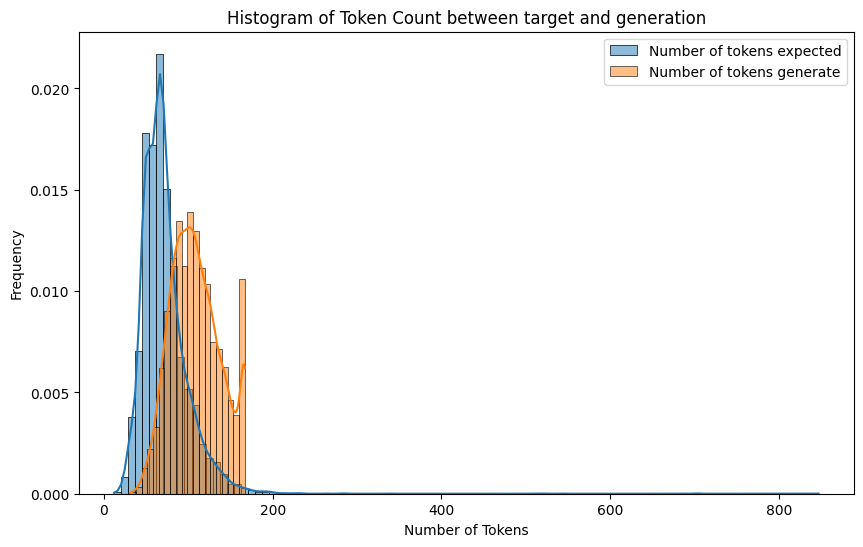

In [79]:

# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_len, x="target_len", bins=100, kde=True, label='Number of tokens expected',stat="density")
sns.histplot(data=data_len, x="generate_len", bins=20, kde=True, label='Number of tokens generate',stat="density")
# Add title, labels, and legend
plt.title('Histogram of Token Count between target and generation')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


## Compression ratio distribution

In [86]:
data_len.describe()

,input_len,target_len,generate_len,compression_ratio,compression_ratio_generate,ratio_resume_article,ratio_generate_resume_article
count,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000,11490.000000
mean,858.563969,72.049869,108.956571,89.523156,84.448671,10.476844,15.551329
std,440.230117,28.992050,29.390737,9.544727,7.434774,9.544727,7.434774
min,66.000000,12.000000,31.000000,-647.872340,15.555556,1.096163,1.767352
25%,524.000000,54.000000,87.000000,86.927480,80.741963,6.263982,10.304673
50%,772.000000,67.000000,106.000000,90.946716,85.734266,9.053284,14.265734
75%,1095.000000,83.000000,129.000000,93.736018,89.695327,13.072520,19.258037
max,3112.000000,847.000000,167.000000,98.903837,98.232648,747.872340,84.444444


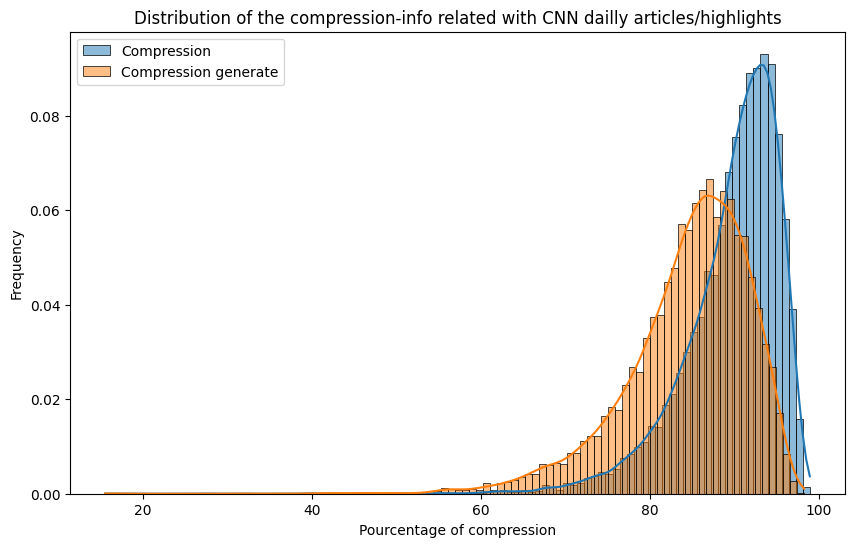

In [85]:
# Create the Seaborn histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=data_len[(data_len.compression_ratio <=100) & (data_len.compression_ratio > 0)], x="compression_ratio", bins=100, kde=True, label='Compression',stat="density")
sns.histplot(data=data_len[(data_len.compression_ratio <=100) & (data_len.compression_ratio > 0)], x="compression_ratio_generate", bins=100, kde=True, label='Compression generate',stat="density")

# Add vertical lines for max token and mean token length
#plt.axvline(x=tokenizer.model_max_length, color='r', linestyle='--', label=f'Max token: {tokenizer.model_max_length}')
# plt.axvline(x=data_len["compression_ratio"].mean(), color='g', linestyle='-', label=f'Mean: {data_len["compression_ratio"].mean():.2f}')
# plt.axvline(x=(data_len["compression_ratio"].mean() + 2*data_len["compression_ratio"].std()), color='r', linestyle='-', label=f'Mean + 2std: {data_len["compression_ratio"].mean() + 2 *data_len["compression_ratio"].std():.2f}')

# Add title, labels, and legend
plt.title('Distribution of the compression-info related with CNN dailly articles/highlights')
plt.xlabel('Pourcentage of compression')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show()


## Compute scores 

In [ ]:

from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

# Define the evaluation function
def evaluation_rouge_score(examples):
    """
    Compute ROUGE scores for a batch of generated texts withe the rouge object from rouge_score
    """
    generated_txt = examples["generated_txt"]  # List of generated summaries
    references = examples["references_txt"]  # List of reference summaries

    scores = scorer.score(generated_txt ,references)

    return {
        "rouge1": float(scores["rouge1"].fmeasure),
        "rouge2": float(scores["rouge2"].fmeasure),
        "rougeL": float(scores["rougeL"].fmeasure)
    }
    # return [float(scores["rouge1"].fmeasure), float(scores["rouge2"].fmeasure) ,float(scores["rougeL"].fmeasure)]



In [72]:
df_score = pd.DataFrame(data_len.apply(evaluation_rouge_score, axis=1).tolist(), 
                          columns=["rouge1", "rouge2", "rougeL"])
df_score

,rouge1,rouge2,rougeL
0,0.481013,0.337662,0.430380
1,0.407767,0.198020,0.368932
2,0.405405,0.194444,0.270270
3,0.365591,0.131868,0.258065
4,0.456522,0.088889,0.217391
...,...,...,...
11485,0.415842,0.121212,0.257426
11486,0.533865,0.200803,0.278884
11487,0.558824,0.247525,0.196078
11488,0.280702,0.178571,0.263158


In [ ]:
data_len = pd.concat([data_len,df_score], axis=1)
# data_len.to_csv(os.path.join(os.getcwd(),"evaluations/results_evaluation_6497751_43_11/len_and_txt_and_score.csv"),index=False)

In [155]:
exemple = data_len[data_len.rougeL<0.25].sample()
print("score RL : " ,exemple.rougeL.values)
print("expected :", exemple.references_txt.values)
print("generate :",exemple.generated_txt.values)

score RL :  [0.21212121]
expected : ['The man records himself descending mountain with fellow skier .\nHe negotiates a number of trees and video is initially a success .\nPair stop but the snowboarder fails to move from path of chairlift .\nWhile posing for the camera the chairlift hits him hard in the head .\nThe footage was recorded in the Chiisagata District of Japan .']
generate : ['A snowboarder in Japan is decked out in purple holding a matching selfie stick at arm’s length.\nRecording himself from behind, the man begins his descent of the mountain.\nBut as he adjusts the camera, he is oblivious to the chairlift swinging into view behind.\nThe empty chairlift deals him a heavy blow to the head while still filming himself.\nSnowboarder can be heard making a scream as he holds the back of his head.']


## Local test with the Bart-large-finetune

In [126]:
from transformers import BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("./checkpoints/Bart-large-2025-03-07_12h44-6473173", forced_bos_token_id=0)
tok = BartTokenizer.from_pretrained("./checkpoints/Bart-large-2025-03-07_12h44-6473173")
example_english_phrase = "What is the color of the <mask> ?"
batch = tok(example_english_phrase, return_tensors="pt")



In [129]:
generated_ids = model.generate(batch["input_ids"],early_stopping=True,do_sample=True)

tok.batch_decode(generated_ids,skip_special_tokens=True)

['The color of the man in the moon.What is the color of the moon?']

In [130]:
from transformers import BartForConditionalGeneration, BartTokenizer

model = BartForConditionalGeneration.from_pretrained("facebook/bart-large", forced_bos_token_id=0)
tok = BartTokenizer.from_pretrained("facebook/bart-large")
example_english_phrase = "What is the color of the <mask> ?"
batch = tok(example_english_phrase, return_tensors="pt")

/home/ivanhoe/Bureau/length-control-for-summarization/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [148]:
generated_ids = model.generate(batch["input_ids"],early_stopping=True,do_sample=True)

tok.batch_decode(generated_ids,skip_special_tokens=True)

['What is the color of the human eye ?']

In [ ]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("./checkpoints/Bart-large-2025-03-07_12h44-6473173")
model.generation_config

Some weights of BartForCausalLM were not initialized from the model checkpoint at ./checkpoints/Bart-large-2025-03-07_12h44-6473173 and are newly initialized: ['lm_head.weight', 'model.decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}

In [152]:
model.generation_config

GenerationConfig {
  "bos_token_id": 0,
  "decoder_start_token_id": 2,
  "early_stopping": true,
  "eos_token_id": 2,
  "forced_bos_token_id": 0,
  "forced_eos_token_id": 2,
  "no_repeat_ngram_size": 3,
  "num_beams": 4,
  "pad_token_id": 1
}